<a href="https://colab.research.google.com/github/CassieHuang22/CIS581-Final-Project-Masked-Facial-Recognition/blob/main/visualization_demo_unmasked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizations and Demo for Unmasked Faces
The following notebook creates a confusion matrix for our unmasked dataset and runs a demo using new photos not in the data.

In [ ]:
!pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 8.7 MB/s 


In [ ]:
import torchvision
import torch
from torchvision import transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from facenet_pytorch import InceptionResnetV1
import numpy as np
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/MyDrive/Colab Notebooks/CIS-5810/Project/Visulatisations"

/content/drive/MyDrive/Colab Notebooks/CIS-5810/Project/Visulatisations


## Model

In [ ]:
class face_rec(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.inception_resnet = InceptionResnetV1(pretrained='vggface2').eval()
    self.fc_layers = torch.nn.Sequential(torch.nn.Linear(512, 1), torch.nn.Sigmoid())

  def forward(self, img1, img2):
    encoding_1 = self.inception_resnet(img1)
    encoding_2 = self.inception_resnet(img2)
    input_fc = torch.abs(encoding_1 - encoding_2)
    out = self.fc_layers(input_fc)
    return out

## Evaluation

In [ ]:
test_transforms = transforms.Compose([transforms.Resize((160, 160)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

In [ ]:
lfw_test = torchvision.datasets.LFWPairs(".", split='test', download=True, transform=test_transforms)

  0%|          | 0/243346528 [00:00<?, ?it/s]

Extracting ./lfw-py/lfw-funneled.tgz to ./lfw-py


  0%|          | 0/26002 [00:00<?, ?it/s]

In [ ]:
testloader = torch.utils.data.DataLoader(lfw_test, batch_size=16)

In [ ]:
model = face_rec().to(device)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
model.load_state_dict(torch.load('weights_lr0.001_wd0.0075_epoch20'))

<All keys matched successfully>

In [ ]:
model.eval()

In [ ]:
def evaluate_model(net):
  criterion = torch.nn.BCELoss()
  with torch.no_grad():
      correct = 0
      total = 0
      val_loss = 0
      count = 0 
      for test_img1, test_img2, labels in testloader:
        test_images1 = test_img1.to(device)
        test_images2 = test_img2.to(device)
        labels = labels.to(device)
        outputs = net(test_images1, test_images2)
        val_loss += criterion(torch.flatten(outputs), labels.float()).item() * test_images1.shape[0]
        predictions = torch.flatten(torch.tensor(outputs.clone().detach() > 0.5, dtype=int))
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
  return correct / total

In [ ]:
evaluate_model(model)

<ipython-input-16-4e78f8d4690b>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.flatten(torch.tensor(outputs.clone().detach() > 0.5, dtype=int))


0.917

## Creating Confusion Matrix

In [ ]:
to_pil = transforms.ToPILImage()

In [ ]:
predictions_all = np.array([])
labels_all = np.array([])

In [ ]:
# To generate confusion matrix
for test_img1, test_img2, labels in testloader:
      test_images1 = test_img1.to(device)
      test_images2 = test_img2.to(device)
      labels = labels.to(device)
      outputs = model(test_images1, test_images2)
      predictions = torch.flatten(torch.tensor(outputs.clone().detach() > 0.5, dtype=int))
      predictions_all = np.hstack([predictions_all, predictions.cpu().detach().numpy()])
      labels_all = np.hstack([labels_all, labels.cpu().detach().numpy()])
      #vis_img1 = to_pil(((test_images1[1, :, :, :] * 0.5) + 0.5))
      #vis_img2 = to_pil(((test_images2[1, :, :, :] * 0.5) + 0.5))

<ipython-input-66-54b2ef85909c>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.flatten(torch.tensor(outputs.clone().detach() > 0.5, dtype=int))


In [ ]:
from sklearn.metrics import confusion_matrix
cm_matrix = confusion_matrix(labels_all, predictions_all)

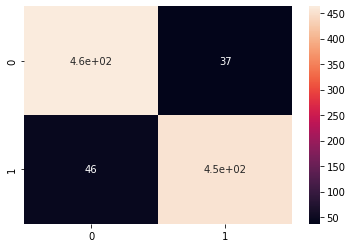

In [ ]:
import pandas as pd
import seaborn as sns
cm_df = pd.DataFrame(cm_matrix)
sns.heatmap(cm_df, annot=True)

## Demo

In [ ]:
def verify(img1_path, img2_path):
  img1 = Image.open(img1_path)
  img1_t = test_transforms(img1).reshape(-1, 3, 160, 160).to(device)
  img2 = Image.open(img2_path)
  img2_t = test_transforms(img2).reshape(-1, 3, 160, 160).to(device)
  output = model(img1_t, img2_t)
  if output.item() > 0.5:
    return 1
  else:
    return 0


In [ ]:
resize = transforms.Resize((160, 160))

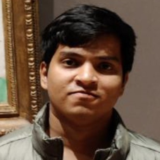

In [ ]:
resize(Image.open('Vaibhav/Vaibhav_0001.jpeg'))

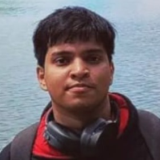

In [ ]:
resize(Image.open('Vaibhav/Vaibhav_0002.jpeg'))

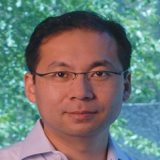

In [ ]:
resize(Image.open('Jianbo/Jianbo_0001.jpeg'))

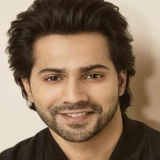

In [ ]:
resize(Image.open('Varun/Varun_0001.jpeg'))

In [ ]:
verify('Vaibhav/Vaibhav_0001.jpeg', 'Vaibhav/Vaibhav_0002.jpeg')

1

In [ ]:
verify('Vaibhav/Vaibhav_0001.jpeg', 'Jianbo/Jianbo_0001.jpeg')

0

In [ ]:
verify('Vaibhav/Vaibhav_0001.jpeg', 'Varun/Varun_0001.jpeg')

0